In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Verify # of computer cores being leveraged by SKLearn (Joblib)
import multiprocessing
multiprocessing.cpu_count()

8

### Load the data and show a sample image

In [2]:
def load_data(file, label='label', rnd_seed=43, print_info=True):
    """Load data in, shuffle it, and convert it to an ndarray"""
    df = pd.read_csv(file)
    
#     df = df.sample(n=25000, random_state=rnd_seed).reset_index(drop=True)
    
    x = df[[col for col in df.columns if col != label]].to_numpy()
    y = df[label].to_numpy()

    if print_info:
        show_dataset_info(x,y)
    return df, x, y

def show_dataset_info(x,y):
    """Print some information about the data set"""
    print('x has shape {}'.format(x.shape))
    print('a sample of x has shape {}'.format(x[0].shape))
    print('y has shape {}'.format(y.shape))
    print('a sample of y has shape {}'.format(y[0].shape))
    print('a sample image looks like...')
    plt.imshow(x[0].reshape(28,28), cmap='gray', interpolation='nearest')

x has shape (42000, 784)
a sample of x has shape (784,)
y has shape (42000,)
a sample of y has shape ()
a sample image looks like...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


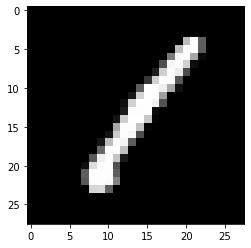

In [3]:
df, X, y = load_data('train.csv')
print(df.info())
df.describe()

### Observations
- There are 42k images x 785 pixels each ~ 33M individual data points in this data set
- Woah that's really cool! It sounds simple but to see that an image is really just 
  an array of integers that can be desplayed graphically is pretty marvelous
- There is a lot of black space around the image
- many of the columns (pixels) appear to have all 0's in them
    - this means they may not contain useful information and may just be extra memory consumers 
      as well as hurt the algorithm from learning at all (or quickly)

In [4]:
# Are there a reasonable numbers of numbers to train on for each number? 
print(df.groupby('label')['label'].count().tolist())
# How many pixels are actually always 0? 
print((df.sum()==0).sum())
# How many pixels are used < 10% of the time? 
ten_pct_thresh = df.shape[0]/10 
print((df.sum()<ten_pct_thresh).sum()/len(df.columns))

[4132, 4684, 4177, 4351, 4072, 3795, 4137, 4401, 4063, 4188]
76
0.23821656050955414


### Split data into test and train sets
- Even though I am just using train.csv I still want to split
  my data into train and test values in order to keep test.csv as a 
  holdout set to perform my final predictions on.  
- Since we have a reasonable number of labels for all 10 digits,
  it isn't necessary to do any stratified sampling based on labels

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Test KNN Model
- KNN's are a reasonably simple, all-purpose, out of the box supervised clustering method
  so I'm going to try one of those. 
- Create a K Nearest Neighbors classification model 
- Try grid search that varies K ( and the weights used. 
- I used accuracy as measurement scores since I don't have a specific
use case in mind where I might value (say) reducing false positives. 
- The model was running slow on my computer so I used verbose=10 to print some intermitent results
    - Since KNN scales well w/ larger data sets, sampling probably won't be very effective here

In [11]:
# This takes a while to train so let's reduce the data set size. 
# especially before we try to do a grid search
%time 
knn_clf = KNeighborsClassifier().fit(X[:10000],y[:10000])

UsageError: Line magic function `%%time` not found.


In [ ]:
%%time 
gs.fit(X_train, y_train)

### Reduce size of data set
- (note I did this for practicing algorithm design. In a real world setting
  it probably would make more sense to just sample the data set or perform PCA first)
- Before I try to even look at the accuracy / results, I am going
 to try to speed up the training since it took so long to run
- First I try to trim the images black space around the edges since there
appears to be large borders that don't contain any information. 
- I wrote a function to trim a single image and then realized there might be 
a faster way to to trim the images where I don't 'for loop' through each image
since I want all the images to be the same size. 

In [12]:
def trim_one_image(image, tol=10):
    """Trim a single image to a specific tolerance"""
    valid_mask = image>tol
    valid_rows = valid_mask.any(1)
    valid_cols = valid_mask.any(0)
    valid_indices = np.ix_(valid_rows, valid_cols)
    trimmed_image = image[valid_indices]
    
    return trimmed_image

(28, 28) 6272
(16, 20) 2560
------------------------


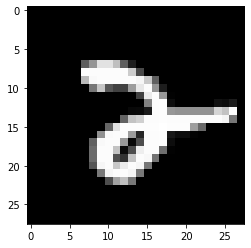

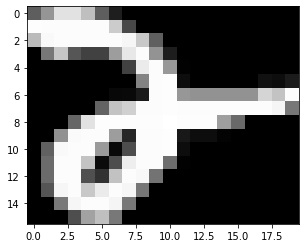

In [29]:
sample_image = X[34].reshape(28,28)
result = trim_one_image(sample_image,100)

print(sample_image.shape, sample_image.size*sample_image.itemsize)
print(result.shape, result.size*result.itemsize)
print("------------------------")
plt.imshow(sample_image.reshape(28,28), cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(result, cmap='gray', interpolation='nearest')
plt.show()

- Nice! The image size reduction worked on a single image
- Running this across all images and then taking the max size 
  might work with some tweaking, but let's try vectorizing this
  logic for speed-sake

In [13]:
def trim_all_images(input_array,tol=10):
    """Trim the blackspace around an group of images to a specific tolerance
    Input: A x B x C array of A images of size B x C
    Method: Check each row and column to see if they contain any non-black pixels
    Output: A x D x E array where there are still A images but they've been
            shrunken down such that D <= B and E <= C
    """
    keep_rows = []
    for row in range(input_array.shape[1]):
        temp_arr = input_array[:,row,:]
        mask = temp_arr>tol
        keep = mask.any()
        if keep:
            keep_rows.append(row)

    keep_cols = []
    for col in range(input_array.shape[2]):
        temp_arr = input_array[:,:,col]
        mask = temp_arr>tol
        keep = mask.any()
        if keep:
            keep_cols.append(col)

    keep_images = [x for x in range(input_array.shape[0])]

    final_arr = input_array[np.ix_(keep_images,keep_rows, keep_cols)]
    
    return final_arr

Note: The speed of this is much faster than looping through each image individually
since we've vectorized the masking (ex. check all row 0's at once). However, this
might be able to be sped up even faster since I still have two for loops. In our 
use case this really isn't terrible since we loop through 28 columns and 28 rows. 

(42000, 28, 28) 263424000
(42000, 28, 28) 263424000
------------------------


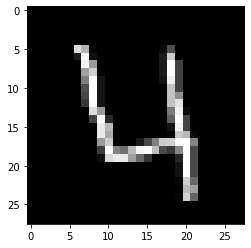

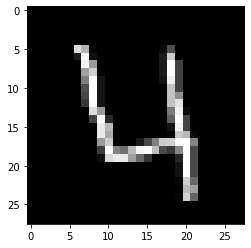

In [32]:
result = trim_all_images(X.reshape(len(X),28,28),100)

print(X.reshape(len(X),28,28).shape, X.size*X.itemsize)
print(result.shape, result.size*result.itemsize)
print("------------------------")
plt.imshow(X[3].reshape(28,28), cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(result[3], cmap='gray', interpolation='nearest')
plt.show()

### Observations 
- From the above, we can see the images only get shrunk from 28x28 to 27x27
- This only reduces the side of the data set by ~7% which isn't negligible but
  definitely can be improved. 
- It looks like my hypothesis that there was a lot of black space around each 
  photo turned out to be invalid. 

### Principle Component Analysis
- Let's instad try applying Principle Components Analysis to see if we can
  reduce the size of the dataset without losing too much information 
- This will allow us to quickly reduce the size of the data set, while ensuring
  we retain the variance in columns (presumably, the "information" contained in 
  the data set

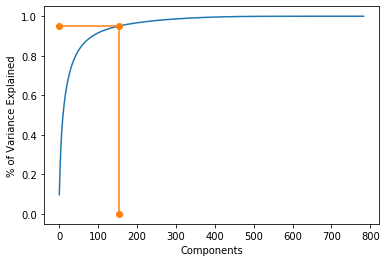

154 components (vs 784 pixels) needed to account for 95% of the variance


In [36]:
pca = PCA()
pca.fit(X)
explained_var = pca.explained_variance_ratio_
explained_var_cum = np.cumsum(explained_var)
components_needed = len(explained_var_cum[explained_var_cum<.95])+1
plt.plot(explained_var_cum)   
plt.plot([components_needed,components_needed,0],[0,.95,.95],'-o')
plt.ylabel('% of Variance Explained')
plt.xlabel('Components')
plt.show()
print("{} components (vs 784 pixels) needed to account for 95% of the variance".format(components_needed))

In [37]:
# Now let's fit the data to our PCA model using 154 components
X_PCAed = PCA(154).fit_transform(X, y)

In [44]:
# How much did this reduce our memory down by? 
old_size = X.shape
old_memory = X.size*X.itemsize
new_size = X_PCAed.shape
new_memory = X_PCAed.size*X_PCAed.itemsize
print('old data shape had shape {} and memory size {}'.format(old_size, old_memory))
print('new data shape had shape {} and memory size {}'.format(new_size, new_memory))
print('This reduced our dataset down by {}%'.format(int(100*(old_memory-new_memory)/old_memory)))

old data shape had shape (42000, 784) and memory size 263424000
new data shape had shape (42000, 154) and memory size 51744000
This reduced our dataset down by 80%


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_PCAed, y, test_size=0.2, random_state=42)

In [52]:
# Now let's try KNN again 
knn_clf = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

In [53]:
knn_clf.score(X_test, y_test)

0.9677380952380953

In [84]:
# Wow a 97% accuracy on the test set
# Let's try a grid search on K and weights parameters 
# and perform cross validation to ensure we're not overfitting

In [54]:
gs_params = {'n_neighbors':list(range(1,16,4)),'weights':['uniform', 'distance']}
gs_scores = {'Accuracy':'accuracy'}
gs = GridSearchCV(KNeighborsClassifier()
             , gs_params
             , refit=False
             , scoring=gs_scores
             , n_jobs=-1
             , verbose=10)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:  5.3min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:  6.5min remaining:   55.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [1, 5, 9, 13],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring={'Accuracy': 'accuracy'}, verbose=10)

In [107]:
# From this we can see that the best combination seems to be 
# 5 neighbors and distance-based weighting 
acc = (100*gs.cv_results_['mean_test_Accuracy']).round(2)
params = [str(p) for p in gs.cv_results_['params']]
results = zip(acc, params)
for res in results:
    print(res)

(96.58, "{'n_neighbors': 1, 'weights': 'uniform'}")
(96.58, "{'n_neighbors': 1, 'weights': 'distance'}")
(96.61, "{'n_neighbors': 5, 'weights': 'uniform'}")
(96.68, "{'n_neighbors': 5, 'weights': 'distance'}")
(96.32, "{'n_neighbors': 9, 'weights': 'uniform'}")
(96.51, "{'n_neighbors': 9, 'weights': 'distance'}")
(96.1, "{'n_neighbors': 13, 'weights': 'uniform'}")
(96.28, "{'n_neighbors': 13, 'weights': 'distance'}")


In [117]:
# Let's refit the model and see how it performs on our holdout test set
knn_clf = KNeighborsClassifier(5, weights='distance').fit(X_train, y_train)
knn_clf.score(X_test, y_test)

0.968452380952381

<Figure size 864x864 with 0 Axes>

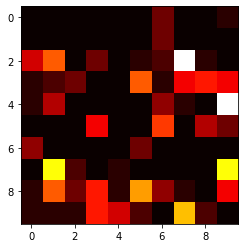

<Figure size 864x864 with 0 Axes>

In [164]:
# Nice we get the accuracy we were looking for
# preds = knn_clf.predict(X_test)
conf_mat = confusion_matrix(y_test, preds)
np.fill_diagonal(conf_mat, 0, int)
plt.imshow(conf_mat, cmap='hot')
plt.figure(figsize=(12,12))

### Next Steps
- We could try to see if picking a new K value near 5 (like 4 or 6) provides better accuracy
- We should try to create new features that help the model distinguish
  2's from 7's and 4's from 9's since that seems to be the biggest opportunity
  based on the confusion matrix. We could do that by creating an algorithm that
  strengthens the  horizontal bar on the bottom of the 2's since the 7's don't have that